# Continuous Batching

The key idea behind continuous batching is constantly swap out requests from the batch that have completed generation for requests in the queue that are waiting to be processed.
- Batching improves throughput at the cost of latency
- Continuous batching provides high throughput and low latency output

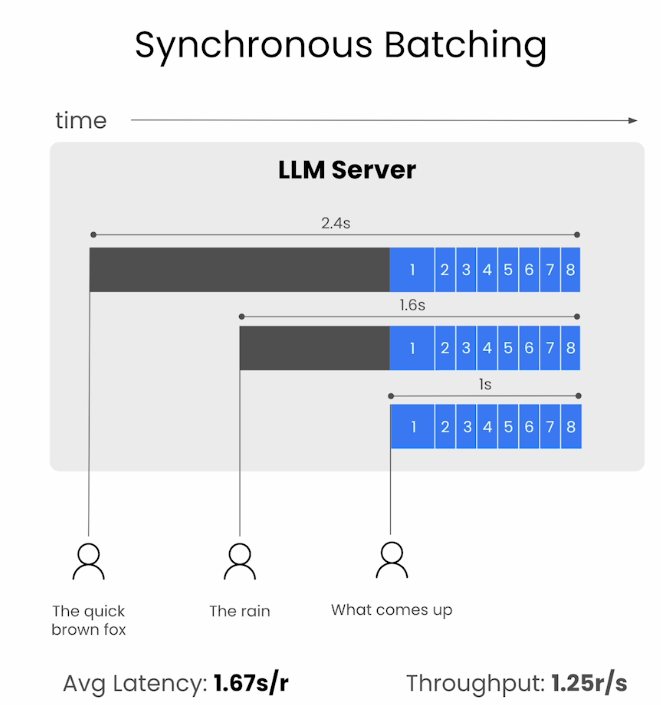
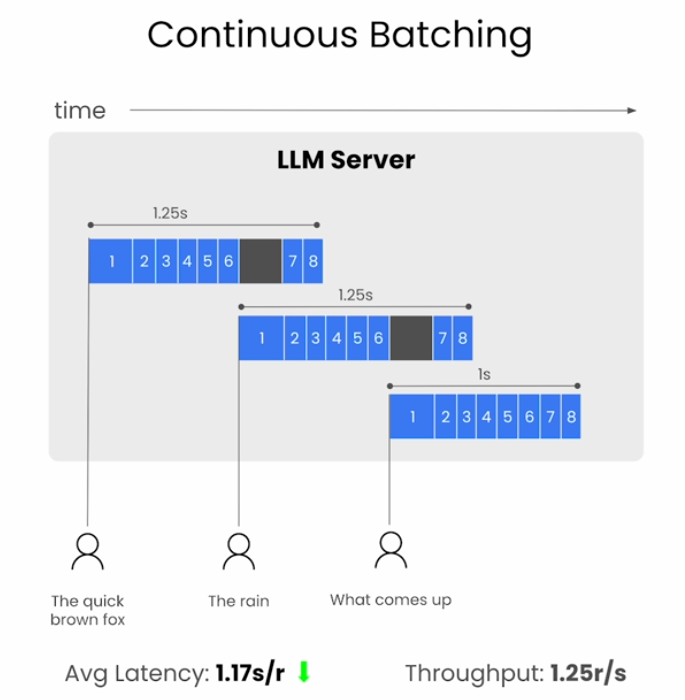

In [5]:
!pip install helpers

In [8]:
# Import all needed functions from Lesson 1 and 2

import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

#### Add padding tokens to the model to prepare batches of prompts

In [9]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [10]:
# multiple prompts of varying lengths to send to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

## Synchronous Batching

In [28]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [[] for _ in range(inputs["input_ids"].shape[0])]
    
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)
    
    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }
    for _ in range(max_tokens):
        next_token_ids, past_key_values = generate_batch_tokens_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),  # '-1' here means the remaining elements for this dim
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,  # increment last, discard the rest
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),  # concatenate vector of 1's with shape [batch_size]
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [29]:
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

In [30]:
request_queue[0:10]

[('The quick brown fox jumped over the', 100),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 100),
 ('The quick brown fox jumped over the', 10)]

The prompt is same but no of token to be generated (100 or 10) are different). Here first request will keep running in the meantime other requests will get fullfilled and new request is added.

In [31]:
batches = [
    request_queue[i:i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

4 batches with each having 8 requests. 

In [32]:
batches[0]

[('The quick brown fox jumped over the', 100),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10)]

In [33]:
# generate tokens for all batches and record duration
t0 = time.time()
with tqdm(total=len(batches), desc=f"bs={batch_size}") as pbar:
    for i, batch in enumerate(batches):
        # to accommodate all the requests with our 
        # current implementation, we take the max of
        # all the tokens to generate among the requests
        batch_max_tokens = [b[1] for b in batch]
        max_tokens = max(batch_max_tokens)
        pbar.set_postfix({'max_tokens': max_tokens})
        
        batch_prompts = [b[0] for b in batch]
        inputs = tokenizer(
            batch_prompts, padding=True, return_tensors="pt")
        op = generate_batch(inputs, max_tokens=max_tokens)
        
        pbar.update(1)

duration_s = time.time() - t0
print("duration", duration_s)

bs=8: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.95s/it, max_tokens=100]

duration 23.832043170928955


In [34]:
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [  464,  2068,  7586, 21831, 11687,   625,   262],
        [  464,  2068,  7586, 21831, 11687,   625,   262],
        [  464,  2068,  7586, 21831, 11687,   625,   262],
        [  464,  2068,  7586, 21831, 11687,   625,   262],
        [  464,  2068,  7586, 21831, 11687,   625,   262],
        [  464,  2068,  7586, 21831, 11687,   625,   262],
        [  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]])}

In [35]:
op

[' fence and ran to the other side of the fence. He was about to run when he saw the fox. He ran to the other side of the fence and ran to the other side of the fence. He ran to the other side of the fence and ran to the other side of the fence. He ran to the other side of the fence and ran to the other side of the fence. He ran to the other side of the fence and ran to the other side of the fence. He ran',
 ' fence and ran to the other side of the fence. He was about to run when he saw the fox. He ran to the other side of the fence and ran to the other side of the fence. He ran to the other side of the fence and ran to the other side of the fence. He ran to the other side of the fence and ran to the other side of the fence. He ran to the other side of the fence and ran to the other side of the fence. He ran',
 ' fence and ran to the other side of the fence. He was about to run when he saw the fox. He ran to the other side of the fence and ran to the other side of the fence. He ran to 

## Continuous batching 

This time, rather than processing each batch to completion, you will use continuous batching to dynamically swap in and out inputs from the queue.

In [38]:
def init_batch(requests):
    prompts = [r[0] for r in requests]
    inputs = tokenizer(prompts, padding=True, return_tensors="pt")
    
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)
    
    return {
        "position_ids": position_ids,
        "responses": copy.copy(prompts),
        "tokens_remaining": [r[1] for r in requests],
        **inputs
    }

def get_next_inputs(batch, next_token_ids, past_key_values, next_tokens):
    return {
        # '-1' here means the remaining elements for this dim
        "input_ids": next_token_ids.reshape((-1, 1)),
        # increment last, discard the rest
        "position_ids": batch["position_ids"][:, -1].unsqueeze(-1) + 1,
        # concatenate vector of 1's with shape [batch_size]
        "attention_mask": torch.cat([
            batch["attention_mask"],
            torch.ones((next_token_ids.shape[0], 1)),  
        ], dim=1),
        "past_key_values": past_key_values,
        "responses": [
            r1 + r2 for r1, r2 
            in zip(batch["responses"], next_tokens)],
        "tokens_remaining": [
            v - 1 for v in batch["tokens_remaining"]],
    }
    
def generate_next_token(batch):
    inputs = copy.copy(batch)
    inputs.pop("responses")
    inputs.pop("tokens_remaining")
    
    next_token_ids, past_key_values = \
        generate_batch_tokens_with_past(inputs)
    next_tokens = tokenizer.batch_decode(next_token_ids)
    return get_next_inputs(
        batch, next_token_ids, past_key_values, next_tokens)

def merge_batches(batch1, batch2):
    # first find the max sequence length of the two batches
    # this can be obtained from the second dimension 
    # of the attention mask
    attn_mask1 = batch1["attention_mask"]
    attn_mask2 = batch2["attention_mask"]
    max_seq_len = max(attn_mask1.shape[1], attn_mask2.shape[1])
    
    # pad each mask (on the left) to the max sequence length
    # attention mask uses 0 for padding
    padding1 = max_seq_len - attn_mask1.shape[1]
    padding2 = max_seq_len - attn_mask2.shape[1]
    attn_mask1 = F.pad(attn_mask1, (padding1, 0), "constant", 0)
    attn_mask2 = F.pad(attn_mask2, (padding2, 0), "constant", 0)
    
    # because we only append batches post decoding, 
    # we don't need to pad input_ids
    # or position_ids. these are always length 1 
    # in the sequence dimension
    # however, we do need to pad the 
    # past_key_values, which have shape:
    # [batch_size, num_heads, sequence_length, head_dim]
    past_kv1 = batch1["past_key_values"]
    past_kv2 = batch2["past_key_values"]
    
    padded_kv1 = []
    for i in range(len(past_kv1)):
        k, v = past_kv1[i]
        k = F.pad(k, (0, 0, padding1, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding1, 0), "constant", 0)     
        padded_kv1.append((k, v))
    
    padded_kv2 = []
    for i in range(len(past_kv2)):
        k, v = past_kv2[i]
        k = F.pad(k, (0, 0, padding2, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding2, 0), "constant", 0)     
        padded_kv2.append((k, v))
        
    # now that everything has been padded to have
    # consistent shapes, let's merge
    input_ids = torch.concat(
        [batch1["input_ids"], batch2["input_ids"]], dim=0)
    position_ids = torch.concat(
        [batch1["position_ids"], batch2["position_ids"]], dim=0) 
    attn_mask = torch.concat([attn_mask1, attn_mask2], dim=0)
    
    past_kv = []
    for i in range(len(padded_kv1)):
        k1, v1 = padded_kv1[i]
        k2, v2 = padded_kv2[i]
        k = torch.concat([k1, k2], dim=0)
        v = torch.concat([v1, v2], dim=0)
        past_kv.append((k, v))
    
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attn_mask,
        "past_key_values": past_kv,
        "responses": batch1["responses"] + batch2["responses"],
        "tokens_remaining": batch1["tokens_remaining"] + batch2["tokens_remaining"],
    }


def filter_batch(batch):
    # mark all rows with 0 tokens remaining for removal
    remove_indices = []
    for i, tokens_remaining in enumerate(batch["tokens_remaining"]):
        if tokens_remaining <= 0:
            remove_indices.append(i)
    
    # first, define a mask used to subselect the indices to keep
    # from each tensor, given the indices to remove
    batch_size = batch["input_ids"].size(0)
    mask = torch.ones(batch_size, dtype=torch.bool)
    mask[remove_indices] = False

    # index into the tensors using the mask to remove rows
    input_ids = batch["input_ids"][mask]
    position_ids = batch["position_ids"][mask]
    attention_mask = batch["attention_mask"][mask]
    responses = [
        r 
        for i, r in enumerate(batch["responses"])
        if i not in remove_indices
    ]
    tokens_remaining = [
        v 
        for i, v in enumerate(batch["tokens_remaining"])
        if i not in remove_indices
    ]

    past_key_values = batch["past_key_values"]
    new_past_key_values = []
    for i in range(len(past_key_values)):
        k, v = past_key_values[i]
        k = k[mask]
        v = v[mask]
        new_past_key_values.append((k, v))
    past_key_values = new_past_key_values
    
    if input_ids.size(0) > 0:
        # next, as an optimization to avoid wasting 
        # compute cycles on padding tokens,
        # we will left truncate the attention_mask 
        # and past_key_values to the longest
        # remaining sequence length
        # we obtain the longest sequence length by 
        # looking for the min first non-zero index
        # of the attention mask
        # cumprod ensures we stop accumulating when we see a 1
        zero_mask = attention_mask == 0
        cumprod = zero_mask.cumprod(dim=1)  
        leading_zeros_count = cumprod.sum(dim=1)
        min_leading_zeros = torch.min(leading_zeros_count)
        truncation_offset = min_leading_zeros.item()

        # do the trunction
        attention_mask = attention_mask[:, truncation_offset:]
        past_key_values = past_key_values
        new_past_key_values = []
        for i in range(len(past_key_values)):
            k, v = past_key_values[i]
            k = k[:, :, truncation_offset:, :]
            v = v[:, :, truncation_offset:, :]
            new_past_key_values.append((k, v))
        past_key_values = new_past_key_values
    
    # return the new batch
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attention_mask,
        "past_key_values": past_key_values,
        "responses": responses,
        "tokens_remaining": tokens_remaining,
    }, remove_indices


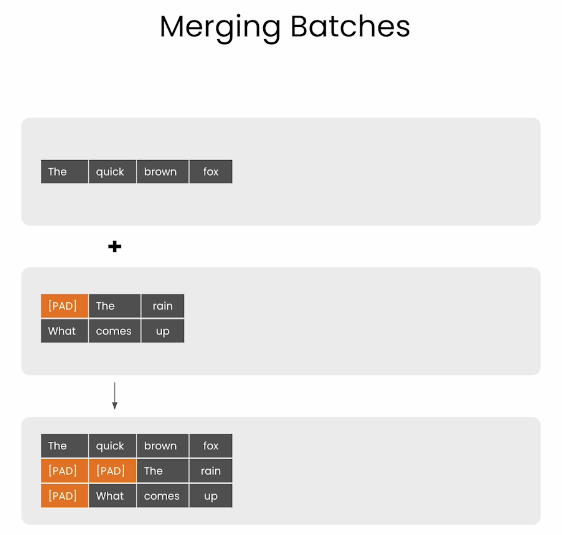
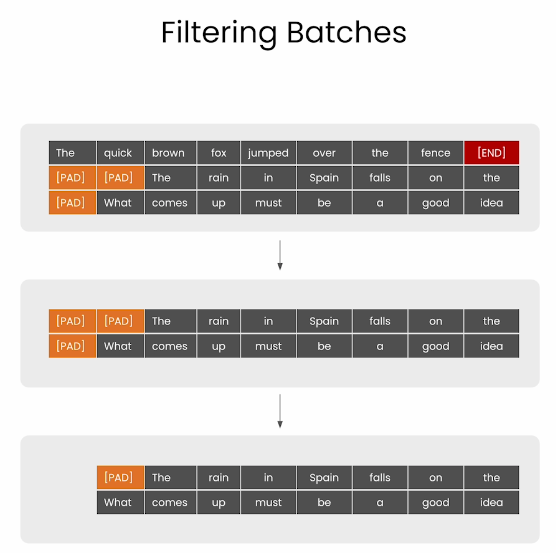

In [39]:
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# this time requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]


In [40]:
t0 = time.time()
with tqdm(total=len(request_queue), desc=f"bs={batch_size}") as pbar:
    # first, let's seed the initial cached_batch
    # with the first `batch_size` inputs
    # and run the initial prefill step
    batch = init_batch(request_queue[:batch_size])
    cached_batch = generate_next_token(batch)
    request_queue = request_queue[batch_size:]

    # continue until both the request queue is 
    # fully drained and every input
    # within the cached_batch has completed generation
    while (
        len(request_queue) > 0 or
        cached_batch["input_ids"].size(0) > 0
    ):
        batch_capacity = (
            batch_size - cached_batch["input_ids"].size(0)
        )
        if batch_capacity > 0 and len(request_queue) > 0:
            # prefill
            new_batch = init_batch(request_queue[:batch_capacity])
            new_batch = generate_next_token(new_batch)
            request_queue = request_queue[batch_capacity:]

            # merge
            cached_batch = merge_batches(cached_batch, new_batch)

        # decode
        cached_batch = generate_next_token(cached_batch)

        # remove any inputs that have finished generation
        cached_batch, removed_indices = filter_batch(cached_batch)
        pbar.update(len(removed_indices))

duration_s = time.time() - t0
print("duration", duration_s)

bs=8: 100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.16it/s]

duration 7.697024345397949


In [41]:
cached_batch

{'input_ids': tensor([], size=(0, 1), dtype=torch.int64),
 'position_ids': tensor([], size=(0, 1), dtype=torch.int64),
 'attention_mask': tensor([], size=(0, 107)),
 'past_key_values': [(tensor([], size=(0, 12, 106, 64)),
   tensor([], size=(0, 12, 106, 64))),
  (tensor([], size=(0, 12, 106, 64)), tensor([], size=(0, 12, 106, 64))),
  (tensor([], size=(0, 12, 106, 64)), tensor([], size=(0, 12, 106, 64))),
  (tensor([], size=(0, 12, 106, 64)), tensor([], size=(0, 12, 106, 64))),
  (tensor([], size=(0, 12, 106, 64)), tensor([], size=(0, 12, 106, 64))),
  (tensor([], size=(0, 12, 106, 64)), tensor([], size=(0, 12, 106, 64))),
  (tensor([], size=(0, 12, 106, 64)), tensor([], size=(0, 12, 106, 64))),
  (tensor([], size=(0, 12, 106, 64)), tensor([], size=(0, 12, 106, 64))),
  (tensor([], size=(0, 12, 106, 64)), tensor([], size=(0, 12, 106, 64))),
  (tensor([], size=(0, 12, 106, 64)), tensor([], size=(0, 12, 106, 64))),
  (tensor([], size=(0, 12, 106, 64)), tensor([], size=(0, 12, 106, 64))),